In [1]:
# data wrangling
import pandas as pd
import numpy as np

# object serialization
import pickle

# GPU acceleration
from numba import jit, cuda

#Timer
from timeit import default_timer as timer 

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

# ML metrics
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

# Data Splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


In [3]:
# read in data
#64x64 data
df = pd.read_csv("C:/Users/conor/OneDrive/Desktop/school/Data Science Minor Independent Study/chest-xray-research/datasets/chest_xray_train_presentation.csv")

#128x128 data
# df = pd.read_csv("C:/Users/conor/OneDrive/Desktop/school/Data Science Minor Independent Study/chest-xray-research/datasets/chest_xray_train_large.csv")

# get all pixel columns
selected_features = list(df.columns)
selected_features.remove("file_name")
selected_features.remove("class_id")

# Set train and target
X = df[selected_features]
y = df['class_id']



With initial tests of training the data, we noticed that our model was having trouble identifying class 2, viral pneumonia. We will now test multiple machine learning models to see if this issue persists.

In [4]:
# Get random split data, only do this once, model should not make data any different
model = svm.SVC()
cross_val = cross_validate(estimator=model,
                           X=X,
                           y=y,
                           cv=10,
                           n_jobs = -1,
                           return_train_score = True,
                           return_estimator = True,
                           return_indices = True)



In [5]:
# Choose a random 10% of the data as testing data
import random
index = random.randint(0,10)
print(index)

8


In [6]:
train_data = cross_val['indices']['train'][index]
test_data = cross_val['indices']['test'][index]

In [10]:
print(train_data.shape)
print(test_data.shape)

(4205,)
(467,)


In [17]:
# Save indices
with open('train_presentation.pickle','wb') as handle:
    pickle.dump(train_data, handle)

with open('test_presentation.pickle','wb') as handle:
    pickle.dump(test_data, handle)

In [18]:
# @jit(target_backend='cuda')	
def build_and_eval_cross_validate_model(model, X, y):

    # Load indicies
    with open('train_presentation.pickle','rb') as handle:
        train_indices = pickle.load(handle)

    with open('test_presentation.pickle','rb') as handle:
        test_indices = pickle.load(handle)

    # Get training and test data
    X_train, X_test = X.iloc[train_indices,:], X.iloc[test_indices,:] 
    y_train, y_test = y[train_indices], y[test_indices]


    # Fit data to model
    model.fit(X_train,y_train)

    # Get metrics
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    acc = accuracy_score(y_pred, y_test) # see scores
    print(acc)
    cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    
    disp.plot()
    
    # return cross_val

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       123
           1       0.77      0.89      0.83       223
           2       0.66      0.47      0.55       121

    accuracy                           0.79       467
   macro avg       0.78      0.76      0.76       467
weighted avg       0.78      0.79      0.78       467

0.7880085653104925


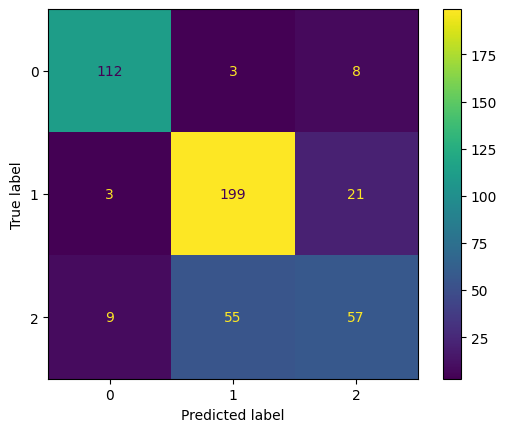

In [19]:
model = svm.SVC()
svm_data = build_and_eval_cross_validate_model(model, X, y)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       123
           1       0.77      0.89      0.82       223
           2       0.70      0.44      0.54       121

    accuracy                           0.78       467
   macro avg       0.78      0.75      0.75       467
weighted avg       0.77      0.78      0.77       467

0.7815845824411135


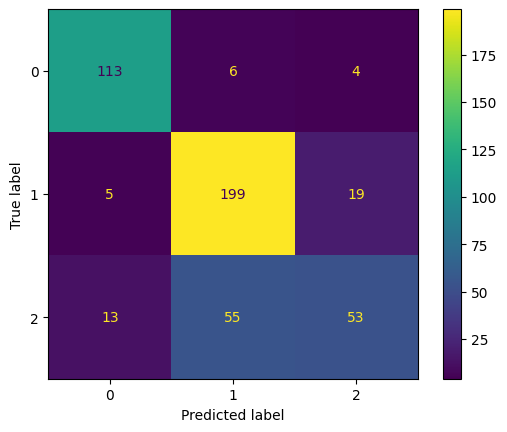

In [20]:
model_rfc = RandomForestClassifier()
rfcdata = build_and_eval_cross_validate_model(model_rfc, X, y)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       123
           1       0.77      0.76      0.76       223
           2       0.55      0.54      0.54       121

    accuracy                           0.72       467
   macro avg       0.71      0.71      0.71       467
weighted avg       0.72      0.72      0.72       467

0.7237687366167024


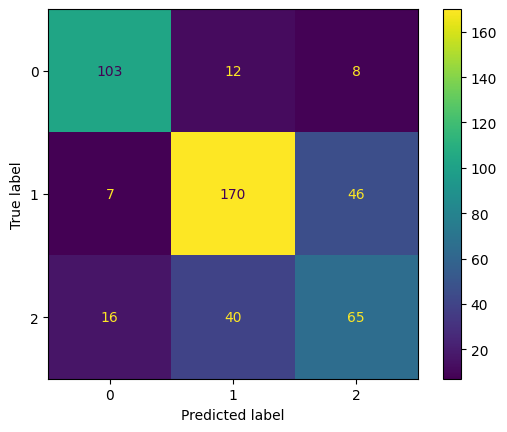

In [27]:
model_lr = LogisticRegression(max_iter = 10000)
lr_data = build_and_eval_cross_validate_model(model_lr, X, y)

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       123
           1       0.74      0.90      0.82       223
           2       0.67      0.44      0.53       121

    accuracy                           0.76       467
   macro avg       0.76      0.73      0.73       467
weighted avg       0.76      0.76      0.75       467

0.7644539614561028


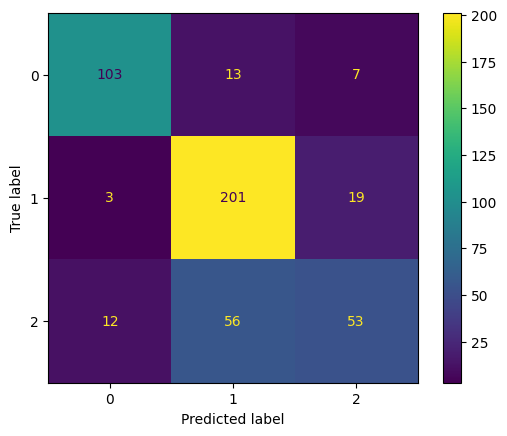

In [22]:
model_knn = KNeighborsClassifier()
knn_data = build_and_eval_cross_validate_model(model_knn, X, y)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       123
           1       0.77      0.72      0.74       223
           2       0.47      0.54      0.50       121

    accuracy                           0.68       467
   macro avg       0.67      0.67      0.67       467
weighted avg       0.69      0.68      0.69       467

0.683083511777302


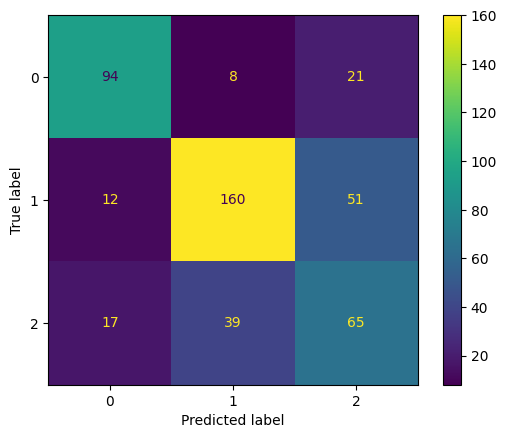

In [23]:
model_nb = MultinomialNB()
nb_data = build_and_eval_cross_validate_model(model_nb, X, y)

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       123
           1       0.90      0.35      0.50       223
           2       0.38      0.74      0.50       121

    accuracy                           0.60       467
   macro avg       0.68      0.67      0.61       467
weighted avg       0.73      0.60      0.59       467

0.5974304068522484


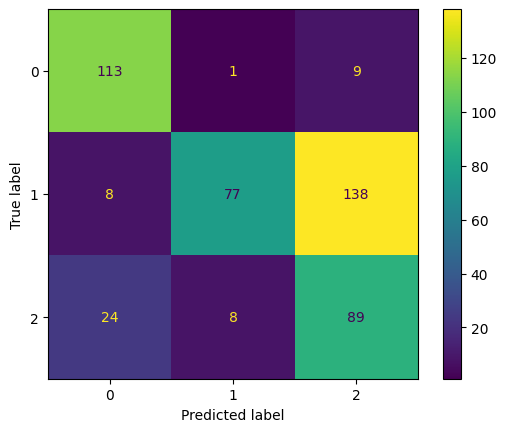

In [24]:
nn_classifier = MLPClassifier()
nn_data = build_and_eval_cross_validate_model(nn_classifier, X, y)

By our results most models still have trouble distinguishing class 1 (Bacterial Pneumonia) and class 2 (Viral Pneumonia). Random Forest Classifier, K Nearnest Neighbors and Support Vector Machine know Class 1 better than Class 2. On the other hand Multinomial Naiive Bayes and Logistic Regression do slightly better on Class 2 but have to trade off knowledge of Class 1 to do it. The Multi Layer Perceptron is the extreme case for this as it does worse on class 1 to do better on class 2.